## Data Download

The first thing we need to do is download the datasources needed for our analysis.

This involves:
-> median income by SA2 level
-> population by SA2 level
-> SA2 Shape files
-> school location data
-> postcode/sa2 data
(see data_download.py in the script folder for details)

In [8]:
%run ../scripts/data_download.py

INFO:root:Beginning zone download
INFO:root:Finished zone download


Archive:  ../data/raw/abs_data/zone_data/zones.zip
  inflating: ../data/raw/abs_data/zone_data/SA2_2021_AUST_GDA2020.dbf  
  inflating: ../data/raw/abs_data/zone_data/SA2_2021_AUST_GDA2020.prj  
  inflating: ../data/raw/abs_data/zone_data/SA2_2021_AUST_GDA2020.shp  

INFO:root:Beginning population download



  inflating: ../data/raw/abs_data/zone_data/SA2_2021_AUST_GDA2020.shx  
  inflating: ../data/raw/abs_data/zone_data/SA2_2021_AUST_GDA2020.xml  


INFO:root:Finished population download
INFO:root:Beginning income download
INFO:root:Finished population download
INFO:root:Beginning population projection download
INFO:root:Finished population projection download
INFO:root:Beginning school download
INFO:root:Finished school download
INFO:root:Beginning postcode download
INFO:root:Finished postcode download


## Scraping

For this project we decided to scrape rental data from domain.com.au.
This website has a huge number of listings, and by searching by postcode we collected a large number of metrics from each listed property.

This process is done in scrape.ipynb, and the results are saved in the raw data folder. as scraped_properties.csv as seen below.
(This will not be run in this notebook as it takes an extremely long time)

In [4]:
import pandas as pd
scraped = pd.read_csv(f"../data/raw/scraped_properties.csv")
scraped.head(3)

,url,price,address,num_beds,num_bath,num_car,property_type,agent,bond,internal_area,...,performance_sold_this_year,performance_avg_days_on_market,demographic_population,demographic_average_age,demographic_owner,demographic_renter,demographic_family,demographic_single,latitude,longitude
0,https://www.domain.com.au/40-esmond-street-ard...,$400,40 Esmond Street Ardeer VIC 3022,3 Beds,2 Baths,1 Parking,House,Create Vic Real Estate,Bond $1738,NaN,...,Sold this year: 37,Avg days on market: 44,"Population: 3,099",Average age: 20 to 39,67%,33%,41%,59%,-37.775134,144.797067
1,https://www.domain.com.au/11-grant-avenue-gisb...,$600.00,11 Grant Avenue Gisborne VIC 3437,4 Beds,2 Baths,1 Parking,House,Brad Teal Woodards Gisborne,Bond $2608,NaN,...,Sold this year: 92,Avg days on market: 41,"Population: 9,000",Average age: 40 to 59,83%,17%,58%,42%,-37.493363,144.595569
2,https://www.domain.com.au/15-balmoral-avenue-b...,$575,15 Balmoral Avenue Bundoora VIC 3083,3 Beds,1 Bath,3 Parking,House,Thomas Quixley Fairfield Pty Ltd,Bond $2499,NaN,...,Sold this year: 229,Avg days on market: 52,"Population: 28,681",Average age: 20 to 39,72%,28%,47%,53%,-37.707414,145.065424


While this gives us a lot of raw data, it needs to be put into a useable format first. This is done in pre_processing.py. By using a variety of regex rules to extract the relevant numbers from the data. We also need to remove a specific NSW town that was caught in the scrape for some reason. We also remove carspaces as they are not relevant to the problems.

From there we merge with the API distance data that has been gathered.

Now we can remove outliers. This is done mainly by plotting a linear regression model using:
-> number of beds
-> number of baths
-> number of parking spaces
-> distance to a school
-> distance to a park
-> distance to a shop
-> bond
and use this to predict rent price.

From this we reject values with a high cooks distance.
(See pre_processing.ipynb for proper details, as the .py file is purely for this notebook)

In [6]:
%run ../scripts/pre_processing.py

Now our data looks like this:

In [12]:
pre_processed = pd.read_csv(f"../data/curated/pre_processed_data.csv")
pre_processed.head(3)

,url,postcode,suburb,state,weekly_rent,bond,num_beds,num_baths,num_parking,property_type,internal_area,land_area,last_sold,other_sold_n_bed_suburb,neighbourhood_under_20,neighbourhood_20_to_39,neighbourhood_40_to_59,neighbourhood_above_60,neighbourhood_long_term_residents,neighbourhood_owners,neighbourhood_renter,neighbourhood_family,neighbourhood_single,performance_median_price,performance_auction_clearance,performance_sold_this_year,performance_avg_days_on_market,demographic_population,demographic_owner,demographic_renter,demographic_family,demographic_single,demographic_average_age,latitude,longitude,school_duration,school_distance,park_duration,park_distance,shop_duration,shop_distance,train_duration,train_distance,stop_duration,stop_distance
0,https://www.domain.com.au/40-esmond-street-ardeer-vic-3022-16035224,3022,esmond,vic,400.0,1738.0,3.0,2.0,1.0,House,NaN,NaN,2018.0,37.0,0.26,0.26,0.26,0.21,0.66,0.74,0.26,0.49,0.51,680000.0,0.56,37.0,44.0,3099.0,0.67,0.33,0.41,0.59,20 to 39,-37.775134,144.797067,8.303333,5332.2,0.101667,42.6,5.595000,2903.6,8.285000,5710.8,1.300000,639.8
1,https://www.domain.com.au/11-grant-avenue-gisborne-vic-3437-16035741,3437,gisborne,vic,600.0,2608.0,4.0,2.0,1.0,House,NaN,NaN,2022.0,92.0,0.25,0.23,0.28,0.24,0.67,0.81,0.19,0.62,0.38,1098000.0,0.69,92.0,41.0,9000.0,0.83,0.17,0.58,0.42,40 to 59,-37.493363,144.595569,1.713333,717.6,16.075000,15921.0,17.856667,17363.3,8.270000,6053.8,1.345000,489.0
2,https://www.domain.com.au/15-balmoral-avenue-bundoora-vic-3083-16058638,3083,balmoral,vic,575.0,2499.0,3.0,1.0,3.0,House,NaN,NaN,2014.0,229.0,0.23,0.26,0.27,0.25,0.79,0.84,0.16,0.57,0.43,830000.0,0.75,229.0,52.0,28681.0,0.72,0.28,0.47,0.53,20 to 39,-37.707414,145.065424,0.858333,214.6,1.670000,423.2,7.698333,3781.9,5.788333,2812.4,1.083333,298.9


We can also add in the SA2 zone and corresponding geometry for each of these listings. This allows us to visualise the data in various ways.

In [34]:
import sys
import os
repo_path = os.path.abspath('../')
sys.path.append(repo_path)
import scripts.addSA2 as addSA2
from matplotlib.pyplot import figure
import geoplot.crs as gcrs
import geopandas as gpd
import geoplot as gplt

sa2_grouped = addSA2.addSA2(pre_processed, use_postcode=False)
sa2_grouped = sa2_grouped.groupby("SA2").mean().reset_index()

shape = gpd.read_file('../data/raw/ShapeFile/SA2_2021_AUST_GDA2020.shp')
shape = shape.loc[shape.STE_NAME21 == "Victoria"]
shape = shape.loc[shape.geometry != None]
shape["SA2_CODE21"] = pd.to_numeric(shape["SA2_CODE21"], errors='ignore')
sa2_grouped = gpd.GeoDataFrame(sa2_grouped.join(shape.set_index("SA2_CODE21")["geometry"], on="SA2"))
sa2_grouped = sa2_grouped[sa2_grouped["geometry"] != None]

If you want to see a plot of any feature, simply type the feature into the "FEATURE HERE" section below:

/home/dylan/.local/lib/python3.8/site-packages/geoplot/geoplot.py:885: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:
/home/dylan/.local/lib/python3.8/site-packages/geoplot/geoplot.py:982: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


<AxesSubplot:>

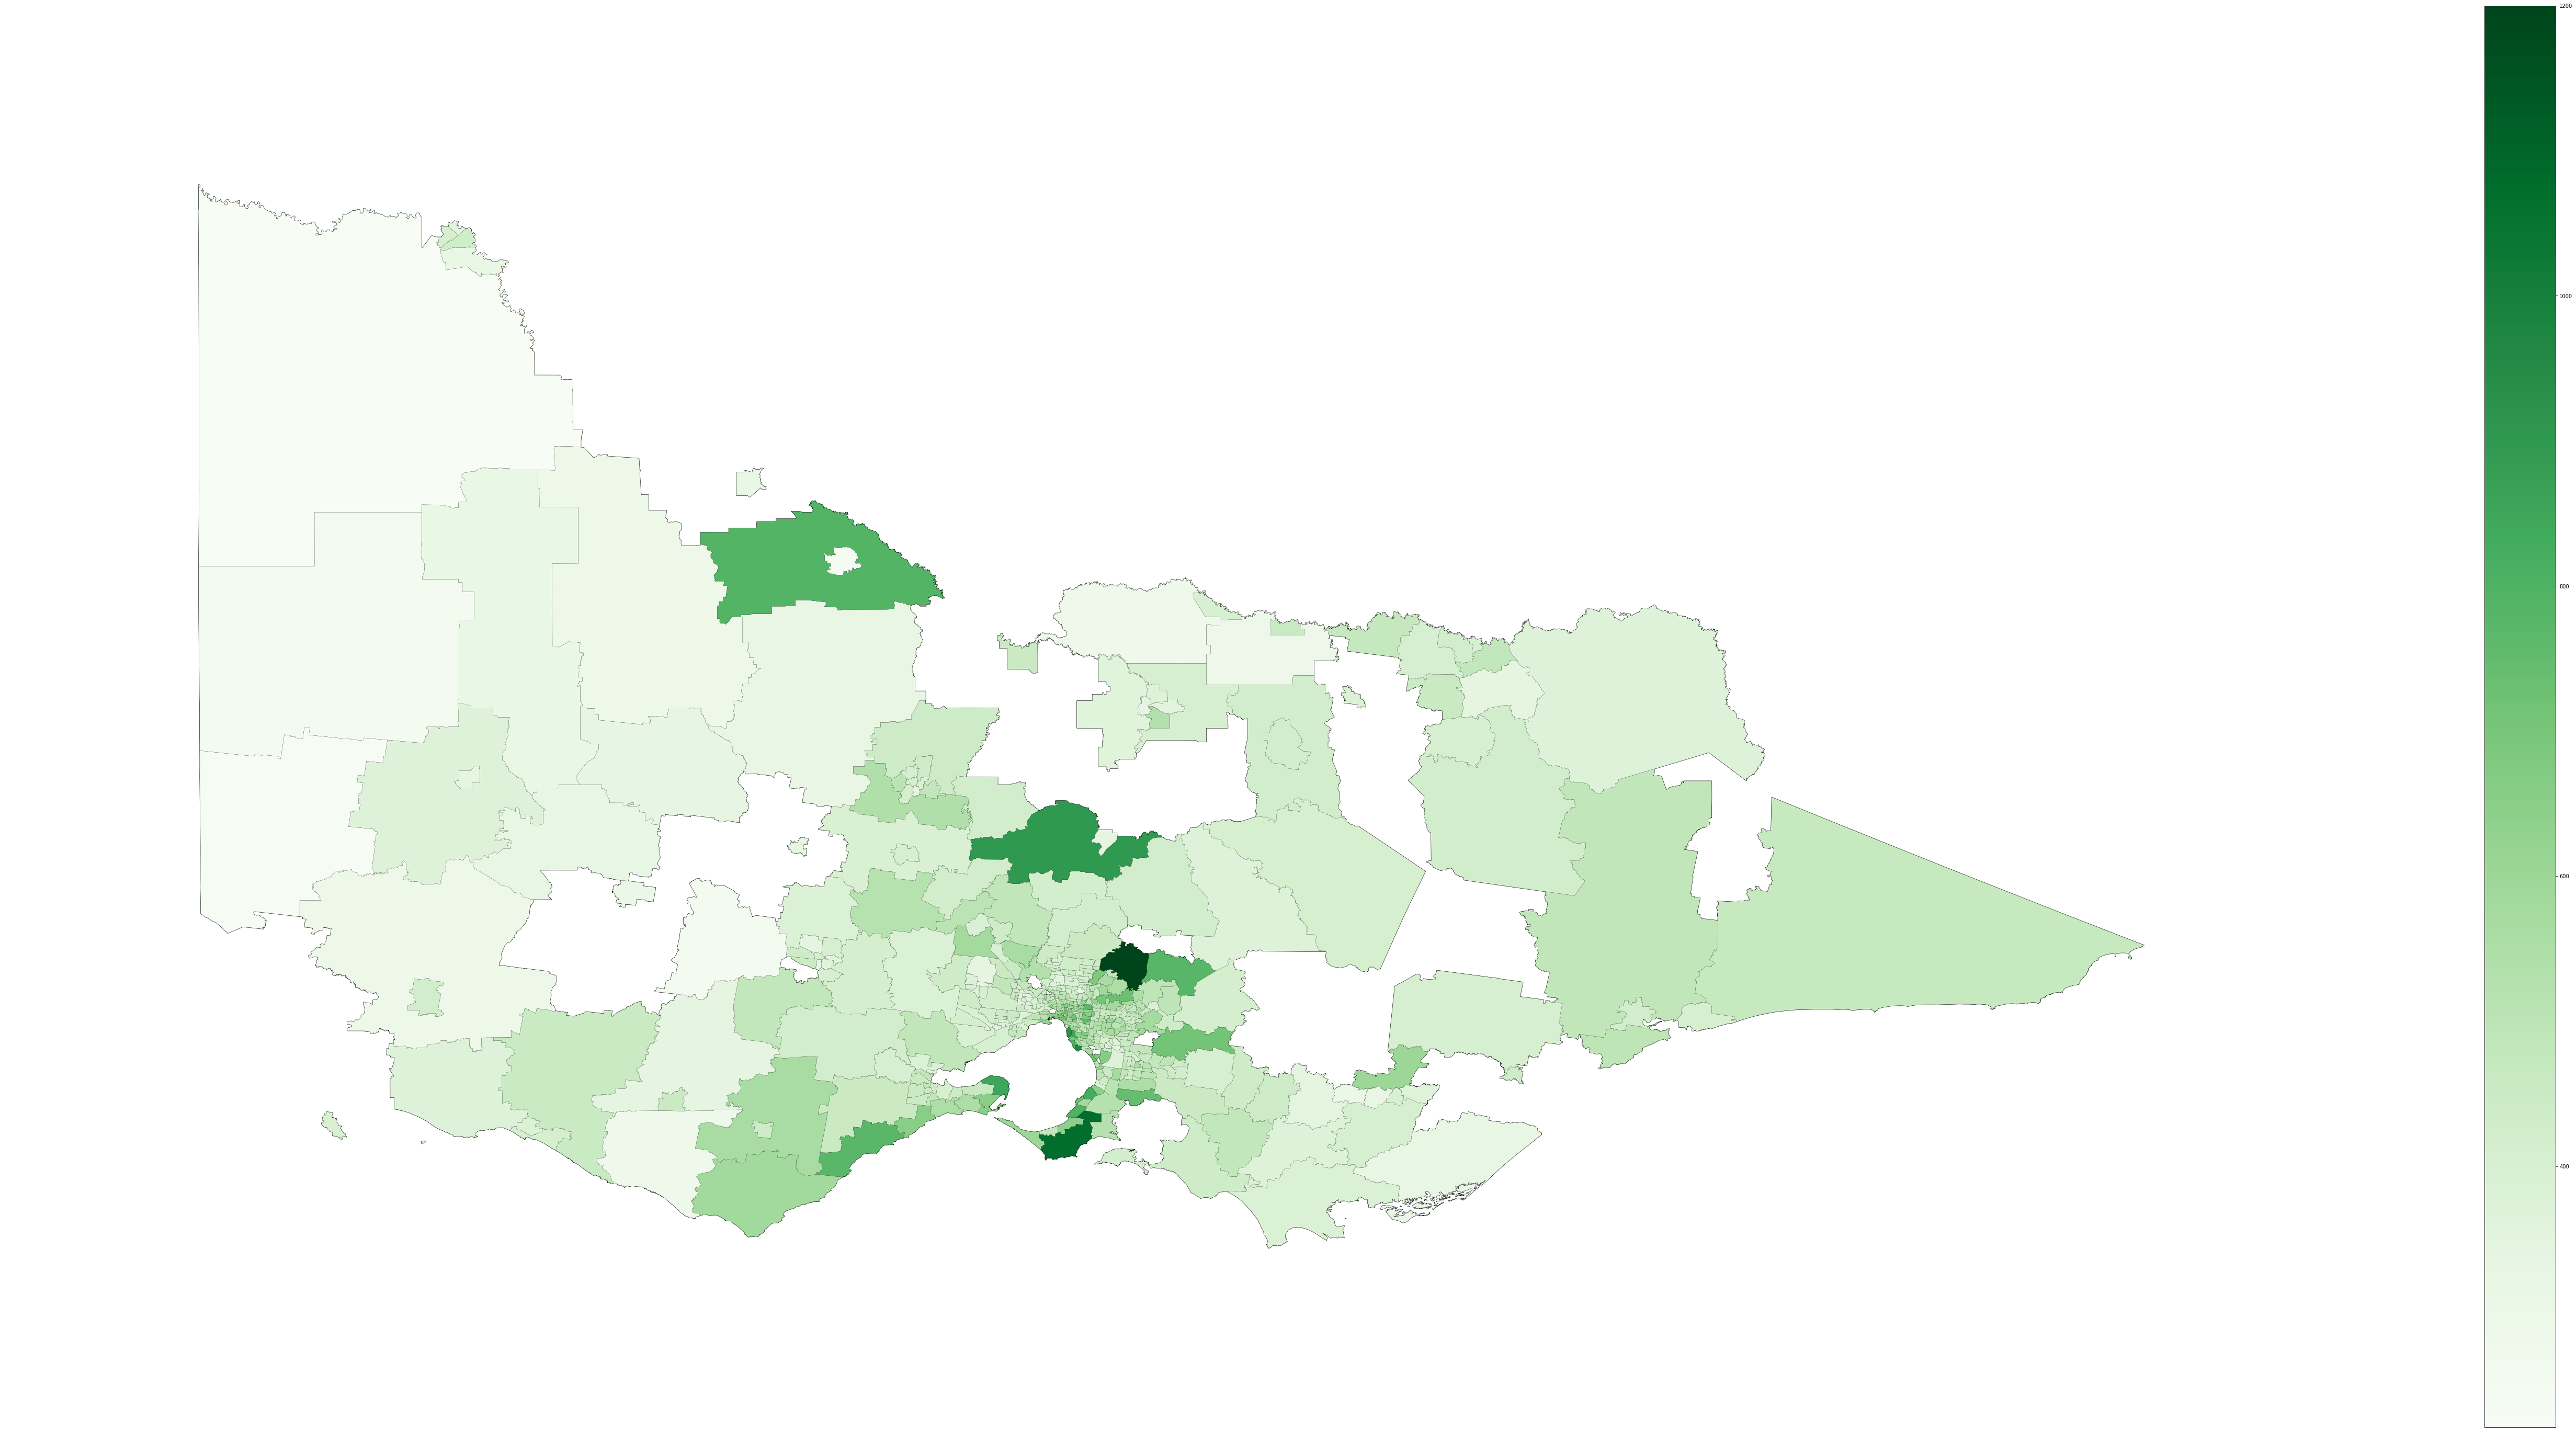

In [35]:
# Plot the lines for the visualisation
ax = gplt.polyplot(sa2_grouped, figsize=(100, 50))
# create a heatmap based on a particular feature
gplt.choropleth(
  sa2_grouped,
  hue="weekly_rent",
  edgecolor="black",
  linewidth=0.1,
  cmap="Greens",
  legend=True,
  ax=ax
)